#### Students Name and ID:
##### 1: Nadav Shaked - 312494925

# Recommender Systems - 2024
# *Homework 1 - Evaluation Metrics*
### Due Jan 11th

### In this assignment you will get familiar with a well known dataset of movie ratings, and explore various RS evaluation metrics. This work will set the grounds for homework 2, in which you will build, optimize and evaluate RS models based on matrix factorization.

#### Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in pairs, by one of the teammates.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

Make sure the entire notebook runs without errors and includes all plots, code and explanations.

After completing the assignment, please download the notebook to an '.ipynb' file and submit it on moodle.

## Data exploration

In this section, you will load the MovieLens 100K rating dataset, extract a rating matix, and get familiar with the data.

The MovieLens 100K is a commonly used dataset, including 100,000 ratings (1-5) from 943 users on 1682 movies. This dataset is considered an explicit feedback dataset for having user ratings (as opposed to implicit feedback datasets where information such as clicks and views are available and can be considered as a proxy for user's preference)

In [53]:
import os
import requests
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [54]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = url.split('/')[-1]
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
with open(zip_name, 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [55]:
cols_data = ['user_id', 'item_id', 'rating', 'timestamp']
cols_user = ['user_id', 'age', 'gender', 'occupation', 'zip code']
cols_item = ['movie id', 'movie_title', 'release_date', 'video_release_date',
             'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
             'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
             'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
             'Thriller', 'War', 'Western']

In [56]:
df_users = pd.read_csv(
    os.path.join(data_dir,'u.user'),
    delimiter='|', header=None, names=cols_user)
df_users.shape

(943, 5)

In [57]:
df_items = pd.read_csv(
    os.path.join(data_dir,'u.item'),
    delimiter='|', header=None, names=cols_item, encoding='ISO-8859-1')
df_items.shape

(1682, 24)

In [58]:
df_ratings = pd.read_csv(
    os.path.join(data_dir,'u.data'),
    delimiter='\t', header=None, names=cols_data)
df_ratings.shape

(100000, 4)

####Question 1 (5 points)

Build a ratings matrix with users as rows, items as columns, and ratings as the elements of the matrix.

Replace empty ratings with zeros.

In [59]:
# Merge df_ratings with df_users to get user information
merged_df = pd.merge(df_ratings, df_users, on='user_id')

# Merge the result with df_items to get item information
merged_df = pd.merge(merged_df, df_items, left_on='item_id', right_on='movie id')

# Extract the relevant columns
ratings_matrix_data = merged_df[['user_id', 'movie id', 'rating']]

# Create the ratings matrix and convert rating cells to float
ratings = pd.pivot_table(ratings_matrix_data, values='rating', index='user_id', columns='movie id', fill_value=0).astype(float)

ratings.head()


movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####Question 2 (5 points)

Calculate the dataset sparsity

Remider:
$$
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [60]:

# Count non-zero values in the ratings matrix
number_of_nonzero_ratings_in_matrix = np.count_nonzero(ratings.values)

number_of_users = ratings.shape[0]
number_of_items = ratings.shape[1]

sparsity = 1 - number_of_nonzero_ratings_in_matrix / (number_of_users * number_of_items)
sparsity

0.9369533063577546

<Axes: ylabel='rating'>

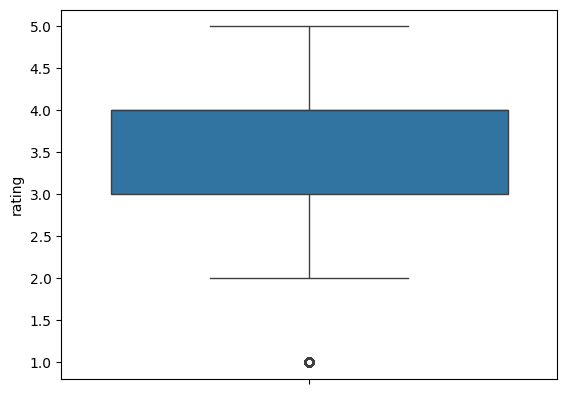

In [61]:
sns.boxplot(df_ratings.rating)

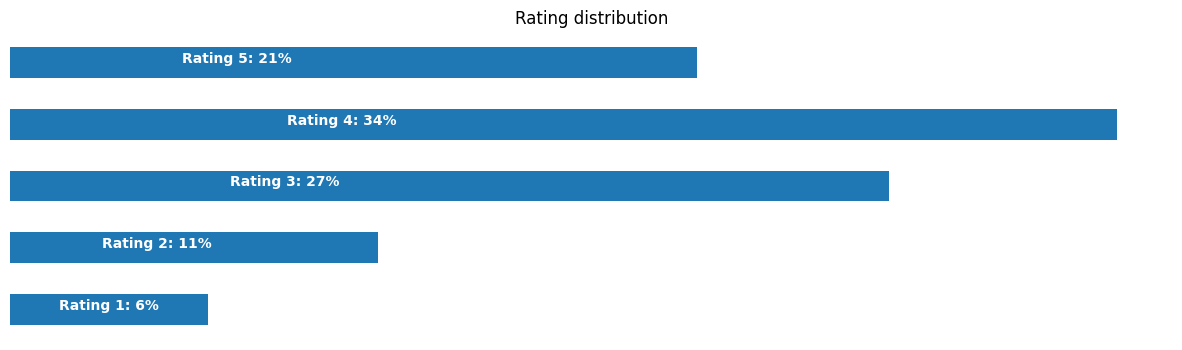

In [62]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])

p.plot(kind='barh', legend=False, figsize=(15,4))
plt.title('Rating distribution')
plt.axis('off')

for i in range(1,6):
    plt.text(
        p.iloc[i-1][0] / 4, i - 1, 'Rating {}: {:.0f}%'.format(
            i, p.iloc[i-1][0] * 100 / p.sum()[0]),
        color = 'white', weight = 'bold')

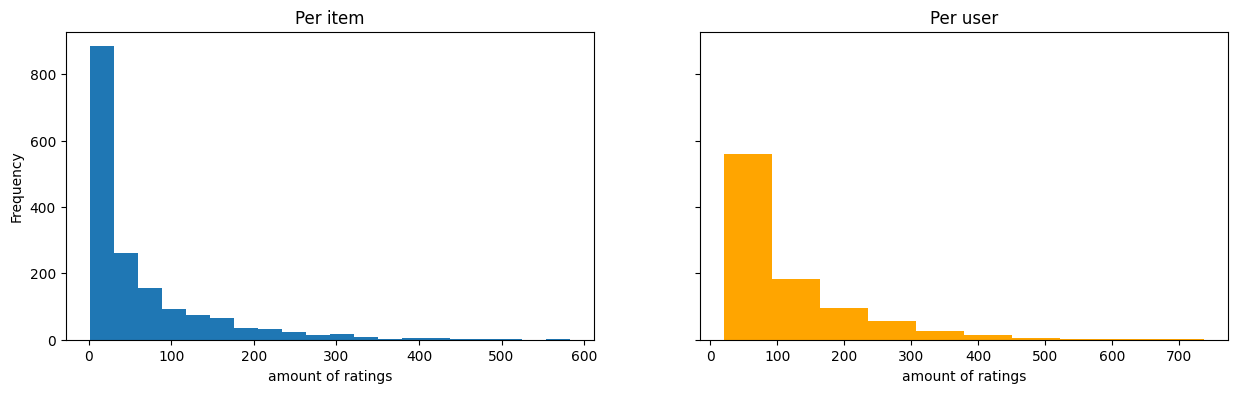

In [63]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0], bins=20)
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1], color='orange', bins=10)
ax[0].set_title('Per item')
ax[1].set_title('Per user')
ax[0].set_xlabel('amount of ratings')
ax[1].set_xlabel('amount of ratings');


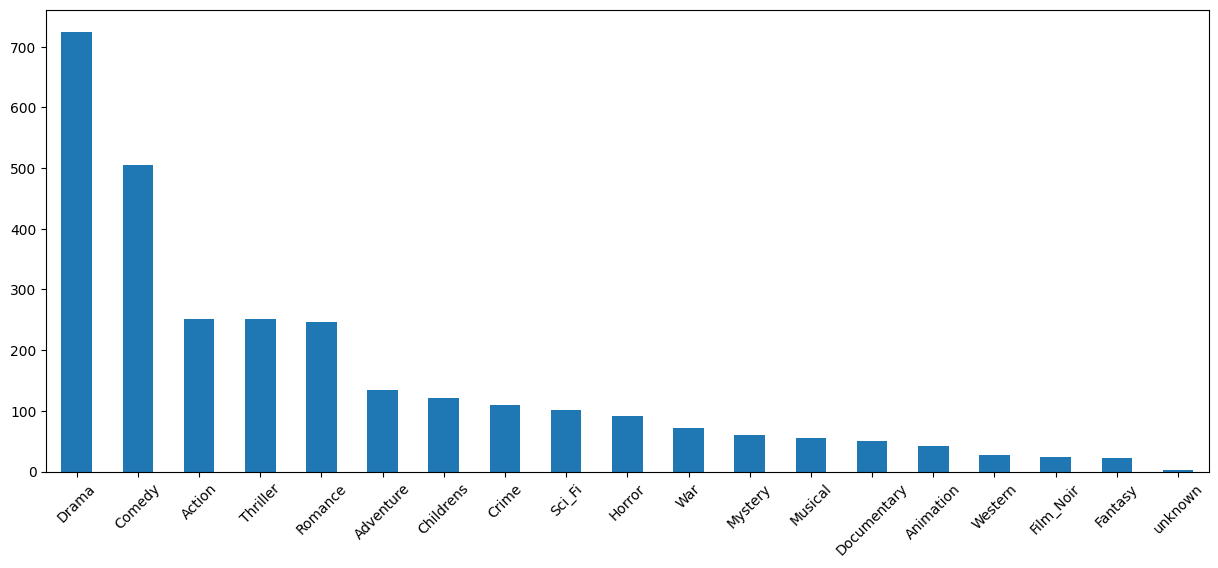

In [64]:
plt.figure(figsize=(15, 6))
df_items.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

####Quetions 3 (10 points)

a. How many items are frequently rated (>100 ratings)?

b. How many items are rarely rated (<10 ratings)?

c. How many users rate frequently (>100 ratings)?

d. How many users rate rarely? (<10 ratings)?

e. What challenges are we facing with when building a recommener system for this specific dataset?


In [65]:
true_counts_per_item_id = ratings.astype(bool).sum(axis=0)
# a.
items_rated_more_than_100 = np.sum(true_counts_per_item_id > 100)

# b.
items_rated_less_than_10 = np.sum(true_counts_per_item_id < 10)

true_counts_per_user_id = ratings.astype(bool).sum(axis=1)
# c.
users_rated_more_than_100 = np.sum(true_counts_per_user_id > 100)

# d.
users_rated_less_than_10 = np.sum(true_counts_per_user_id < 10)

[items_rated_more_than_100, items_rated_less_than_10, users_rated_more_than_100, users_rated_less_than_10]


[334, 530, 361, 0]

a. 334 items are frequently rated

b. 530 items are rarely rated

c. 361 users rate frequently rated

d. 0 users rate rarely rated

e.

Assuming the RS model is popularity based:
1. A significant number of movies have been rated very few times (530 rated less than 10 times). This leads to a lack of statistical confidence in their average ratings. A movie with a high average rating score but based on very few ratings might not be as reliable as one with a slightly lower average rating but based on many more ratings.
2. Doesn't consider data shift - the accumulative nature of the dataset does not consider changes in rating trends or up-to-date preferences on outdated movies.
3. The dataset, tailored to specific users and movies, may not translate well to new markets with different preferences, due to its reliance on the original user group's data.

Assuming the RS model is collaborative based:
1. Sparsity - although this dataset is considered dense, still nearly 94% of user-item combinations are missing. This could limit our desired neighbor size (k) to smaller values on cross user or item calculation.
2. Scalability issues - as the number of users and movies grows, computational complexity becomes a problem.

General challenges:
1. Introducing new items - new items with no rating will not be recommended to users. This requires a "cold start" solution until sufficient reviews are accumulated.

## Popularity based RS model - trainning & evaluation

In this section, you will divide the data into train and test sets, implement and explore various evaluation metrics, and test them on the popularity based RS model.

In [66]:
def train_test_split(
    ratings: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Splits rating matrix to train and test.

    Args:
        ratings: rating matrix.

    Returns:
        Train and test matrices.
    """
    test = ratings.copy()
    test.iloc[:, :] = 0
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        non_zero_items = ratings.iloc[user, :].to_numpy().nonzero()[0]
        test_ratings = np.random.choice(non_zero_items, size=10, replace=False)
        train.iloc[user, test_ratings] = 0
        test.iloc[user, test_ratings] = ratings.iloc[user, test_ratings]

    # Test and training are truly disjoint.
    assert(np.all((train * test) == 0))
    return train, test
train, test = train_test_split(ratings)

train.shape, test.shape

((943, 1682), (943, 1682))

In [67]:
# In order to see the images in the next section
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Quetions 4 (60 points)
Implement the follwoing evaluation metrics using numpy and pandas only:
1. RMSE
2. MRR
3. DCG
4. IDCG
5. nDCG
6. MAP


####Reminder:

<img src='https://drive.google.com/uc?id=1KAaJ5RRHFrMseBTnW1o71ZvrpbrxeQ4f' width="250">

<img src='https://drive.google.com/uc?id=18bVps-_zx07aLcHXFisPQoMaibAJ4nzP' width="250">

<img src='https://drive.google.com/uc?id=1jO7owkzOmcRbHpWn7LgWdq0GNQFD1665' width="350">

<img src='https://drive.google.com/uc?id=1tg-Kl1hYu3WVzQ26fMfA7KQ8S8JqWVnh' width="600">

Notes:
* Refer to the slides about 'Recommender Systems Evaluation' for the math formulas.
* Take into account edge cases such as devision by zero, NaN, Null, Zeros, out of bound, eval time, etc.
* You may change the function signatures (but not required).





In [74]:
class PopularityRS:

    def __init__(self, train: pd.DataFrame):
      """Trains popularity based recommender system model.

        Args:
          train: rating matrix.
      """
      self.train = train
      self.n_users, self.n_items = train.shape
      self.model_params = {}

    def fit_popularity(self):
        """Computes parameters in a popularity-based algorithm."""
        self.model_params['popularity'] = np.zeros(self.train.shape)
        popularity = self.model_params['popularity']
        item_avg = np.ma.masked_equal(self.train, value=0).mean(axis=0)
        item_avg[np.isnan(item_avg)] = 0
        for i in range(1, self.n_items):
            popularity[:, i] = item_avg.data[i]
        self.model_params['popularity'] = popularity

    def recommnd_unseen(self, user: int, n_items: int) -> list:
        """Recommends unseen items per user, oredered by predicted ratings desc.

        Args:
          user: user id.
          n_items: number of items to suggest.

        Returns:
          Top suggestions.
        """
        predicted_ratings = self.model_params['popularity'][user]
        pred_sorted = np.argsort(predicted_ratings)[::-1]
        unseen_movie = np.where(self.train.iloc[user] == 0)
        final = pred_sorted[np.in1d(pred_sorted, unseen_movie)]
        return final[:n_items]

    def predict(self, user: int, item: int) -> float:
        """Predicts the rating of a specific item for a specific user.

        Args:
          user: user id.
          item: item id.

        Returns:
          Predicted rating.
        """
        predicted_rating = self.model_params['popularity'][user, item]
        return predicted_rating

    def predict_all(self):
        """Predicts ratings for every user and item."""
        predictions = np.zeros(shape=(self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                predictions[u, i] = self.predict(u, i)
        return predictions

    def rmse(self, actual: pd.DataFrame) -> float:
        """Computes the total RMSE of a model, compared to the actual rating.

        Args:
          actual: actual rating matrix.

        Returns:
          Total RMSE.
        """
        actual_as_np = actual.to_numpy()

        actual_non_zero_cell_indexes = actual_as_np.nonzero()

        n = len(actual_non_zero_cell_indexes[0])
        if pd.isna(n) or n == 0:
            return 0

        actual_non_zero_rating = actual_as_np[actual_non_zero_cell_indexes]
        pred_non_zero_rating = self.predict_all()[actual_non_zero_cell_indexes]

        rmse_score = np.sqrt(np.mean(actual_non_zero_rating - pred_non_zero_rating) ** 2)

        return rmse_score

    def mrr(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Mean Reciprocal Rank for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          MRR.
        """
        test_as_np = test.to_numpy()
        relevancy_matrix = test_as_np >= 3

        if self.n_users == 0:
            return 0

        mrr = 0
        for user_id in range(self.n_users):
            user_top_k = self.recommnd_unseen(user_id, k)
            is_top_k_selected_items_relevant = relevancy_matrix[user_id][user_top_k]
            first_relevant_index = np.argmax(is_top_k_selected_items_relevant) + 1
            mrr += 1 / first_relevant_index if first_relevant_index > 0 else 0

        return mrr / self.n_users

    def dcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Discounted Cumulative Gain for a specific user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            DCG.
        """
        test_as_np = test.to_numpy()
        user_top_k = self.recommnd_unseen(user, k)
        dcg = test_as_np[user][user_top_k] / np.log2(np.arange(1, k + 1) + 1)
        dcg_sum = dcg.sum()

        return dcg_sum

    def idcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Idealized Discounted Cumulative Gain for a given user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            iDCG.
        """
        test_as_np = test.to_numpy()
        user_top_k = self.recommnd_unseen(user, k)
        user_top_k_sorted = np.argsort(test_as_np[user][user_top_k])
        idcg = user_top_k_sorted / np.log2(np.arange(1, k + 1) + 1)
        idcg_sum = idcg.sum()

        return idcg_sum

    def mean_ndcg(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes Mean Normalized Discounted Cumulative Gain for all users.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Mean nDCG.
        """
        ndcg = 0

        if self.n_users == 0:
            return 0

        for i in range(self.n_users):
            dcg_i = self.dcg(i, test, k)
            idcg_i = self.idcg(i, test, k)

            ndcg_i = dcg_i / idcg_i if idcg_i > 0 else np.inf
            ndcg += ndcg_i

        return ndcg / self.n_users

    def map(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the mean average precision for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Overall MAP.
        """
        test_as_np = test.to_numpy()
        relevancy_matrix = test_as_np >= 3

        map_sum = 0
        divider = np.arange(1, k + 1)
        for user_id in range(self.n_users):
            user_top_k = self.recommnd_unseen(user_id, k)
            is_top_k_selected_items_relevant = relevancy_matrix[user_id][user_top_k]
            average_precision_by_user = np.cumsum(is_top_k_selected_items_relevant) / divider

            relevant_count = 0
            for i in range(len(average_precision_by_user)):
                average_precision_by_user[i] = average_precision_by_user[i] if is_top_k_selected_items_relevant[i] else 0
                relevant_count = relevant_count + 1

            average_precision = average_precision_by_user.sum() / relevant_count
            map_sum = map_sum + average_precision

        return map_sum / self.n_users


Train and evaluate the popularity based model using your metrics:

In [75]:
    model = PopularityRS(train)
    model.fit_popularity()

    EVAL = {}
    EVAL['RMSE_training'] = model.rmse(train)
    EVAL['RMSE_test'] = model.rmse(test)
    EVAL['MRR5_test'] = model.mrr(test, 5)
    EVAL['MRR10_test'] = model.mrr(test, 10)
    EVAL['Mean_NDCG5_test'] = model.mean_ndcg(test, 5)
    EVAL['Mean_NDCG10_test'] = model.mean_ndcg(test, 10)
    EVAL['MAP5_test'] = model.map(test, 5)
    EVAL['MAP10_test'] = model.map(test, 10)

In [76]:
columns = ['RMSE training', 'RMSE test', 'MRR k=5 test', 'MRR k=10 test',
           'Mean NDCG k=5 test', 'Mean NDCG k=10 test', 'MAP k=5 test',
           'MAP k=10 test']
results = [['Poularity model', EVAL['RMSE_training'], EVAL['RMSE_test'],
            EVAL['MRR5_test'], EVAL['MRR10_test'], EVAL['Mean_NDCG5_test'],
            EVAL['Mean_NDCG10_test'], EVAL['MAP5_test'], EVAL['MAP10_test']]]

results = pd.DataFrame(results).set_index(0)
results = results.set_index(results.index.rename('Model / Metric'))
results.columns = columns
results

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test
Model / Metric,,,,,,,,
Poularity model,2.947062,2.944419,0.829993,0.670746,0.313062,0.127888,0.070785,0.043656


####Quetions 5 (10 points)

Discuss what would you consider to be a more suitable evaluation metric for this specific dataset.

This dataset features movie ratings on a scale from 1 to 5, therefore we prefer an evaluation metric that considers not only relevance but also position in the recommendation list. For this reason the most suitable metric for this purpose is the Normalized Discounted Cumulative Gain (nDCG), which effectively captures these aspects. This of course is dependant on the UI, assuming there is limited space and importance to "higher" listed recommendations.

####Quetions 6 (10 points)
Discuss the pros and cons of these evaluation metrics in general.

### RMSE ###
Pros:

Sensitive to Outliers - RMSE gives a relatively high weight to large errors.

Interpretability - It is in the same units as the target variable, making interpretation of the mean error possible. In fact we understood there was an error with the code when we saw the RMSE was around 3 (can't be more than 4, so this raised a red flag).

Cons:

Overly Sensitive to Outliers - This sensitivity can be a disadvantage if the dataset has many outliers.


### MRR ###
Pros:

Simple and Intuitive - gives a quick indication of how well the first relevant result is ranked.

Effective for Single Relevant Item - Useful in scenarios where the most important factor is the rank of the first relevant item.

Cons:

Limited Information - Only considers the rank of the first relevant item, ignoring the performance of the system with respect to all other items.

### nDCG ###
Pros:

Normalized Measure - Allows for the comparison of the performance of ranking algorithms across different data sets or rating metrics.

Accounts for Multiple Relevant Items and Their Rank - Useful in scenarios where the quality of the entire ranked list is important.

Cons:

Complexity - More complex to calculate and understand than simpler metrics like precision or recall.

### MAP ###
Pros:

Considers the Whole Rank - Takes into account the order of all the relevant items and not just the first.


Cons:

Assumes Equal Relevance - Treats all relevant items equally, which may not be suitable for all scenarios.